# Проект: классификация

In [81]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from statistics import  median, mode
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

Подгрузим данные, посмотрим общую информацию

In [82]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [83]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
None


В данных есть пропуски. Посмотрим на их количество

In [84]:
print(df.isnull().sum())

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


Посмотрим на уникальные значения признаков

In [85]:
for col in df.select_dtypes(include=['object']).columns:
    print(f'{col}: {df[col].unique()}')

job: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital: ['married' 'single' 'divorced']
education: ['secondary' 'tertiary' 'primary' 'unknown']
default: ['no' 'yes']
balance: [' 2 343,00 $ ' ' 45,00 $ ' ' 1 270,00 $ ' ... ' 1 594,00 $ '
 ' 2 593,00 $ ' '-134,00 $ ']
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['unknown' 'cellular' 'telephone']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome: ['unknown' 'other' 'failure' 'success']
deposit: ['yes' 'no']


Пропусков нет, однако есть значение uknown в некоторых признаках

Преобразуем признак balance в float и заполним пропуски

In [86]:
# В данных есть запятые пробелы и не алфавитные символы. Очистим и преобразеум к float. 
# Заполним пропуски
def clear_balance(balance):
    if isinstance(balance, str):
        balance = re.sub('[\$\s]', '', balance)
        balance = balance.replace(',', '.')
    return balance

df['balance'] = df['balance'].apply(clear_balance)
df['balance'] = df['balance'].astype(float)

# Среднее значение
mean_value = df['balance'].mean()
print('Среднее значение с пропусками: ', round(mean_value, 3))

# Заполним пропуски средним значением(mean_value)
# Вычислим медианное значение
df['balance'] = df['balance'].fillna(df['balance'].median())
filled_mean_value = df['balance'].mean()
print('Среднее значение без пропусков: ', round(filled_mean_value, 3))



Среднее значение с пропусками:  1529.129
Среднее значение без пропусков:  1526.936


Заменим пропуски в job и education на модальное значение. Под пропусками подразумеваются значение unknown

In [87]:
mod_job = df['job'].mode()[0]
mod_edu = df['education'].mode()[0]
df['job'] = df['job'].apply(lambda x: mod_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: mod_edu if x == 'unknown' else x)

# Убедимся в отсутствии unknown
print('Специальности :\n', df['job'].unique())
print('Образование :\n', df['education'].unique())

# Статистика по используемым специальностям
print('\nСпециальности(статистика): \n', df['job'].value_counts())

# Статистика по образованию
print('Образование(статистика): \n', df['education'].value_counts())

Специальности :
 ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']
Образование :
 ['secondary' 'tertiary' 'primary']

Специальности(статистика): 
 management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64
Образование(статистика): 
 secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64


Вывод: Наиболее популярная специальность management. Наиболее популярное образование secondary
Расчитаем средний баланс для клиентов с самой популярной работой и с самым популярным уровнем образования

In [88]:
mask_job = df['job'] == 'management'
mask_edu = df['education'] == 'secondary'
mean_balance_hit_job_edu = df[mask_job & mask_edu]['balance'].mean()
print('Средний баланс: ', round(mean_balance_hit_job_edu, 3))

Средний баланс:  1598.883


Найдем выбросы

Нижняя граница:  -2241
Верхняя граница:  4063
Количество выбросов:  1057
Количество записей после очистки:  10105


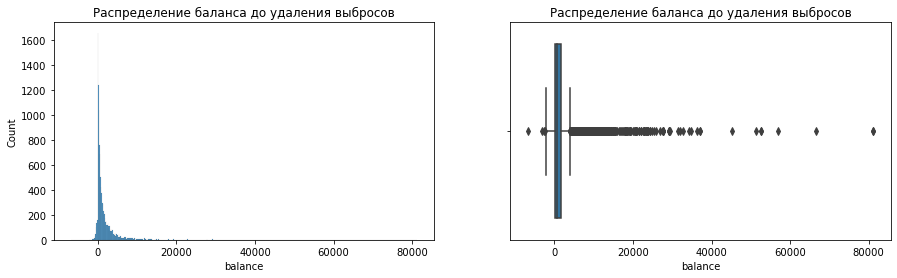

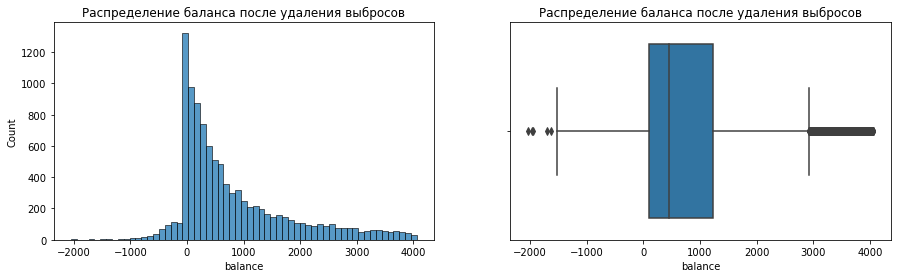

In [89]:
# Определим верхние и нижние границы выбросов
first_quantile = df['balance'].quantile(0.25)
third_quantile = df['balance'].quantile(0.75)
iqr = third_quantile - first_quantile
lower_bound = first_quantile - (iqr * 1.5)
upper_bound = third_quantile + (iqr * 1.5)
print('Нижняя граница: ', round(lower_bound))
print('Верхняя граница: ', round(upper_bound))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Распределение баланса до удаления выбросов');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Распределение баланса до удаления выбросов');

# Удалим выбросы
outliers = df[(df['balance'] < lower_bound) | (df['balance'] > upper_bound)]
print('Количество выбросов: ', outliers.shape[0])
cleaned_data = df[(df['balance'] >= lower_bound)&(df['balance'] <= upper_bound)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_data, x='balance', ax=axes[0]);
histplot.set_title('Распределение баланса после удаления выбросов');
boxplot = sns.boxplot(data=cleaned_data, x='balance', ax=axes[1]);
boxplot.set_title('Распределение баланса после удаления выбросов');

print('Количество записей после очистки: ', cleaned_data.shape[0])


## Разведывательный анализ

Посмотрим распределение целевой переменной

no     5424
yes    4681
Name: deposit, dtype: int64


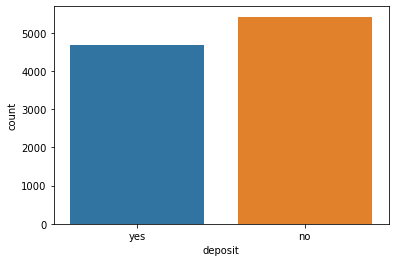

In [90]:
# Значения целевой переменной
print(cleaned_data['deposit'].value_counts())
sns.countplot(data=cleaned_data, x='deposit');

### Описательные статистики

                age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  


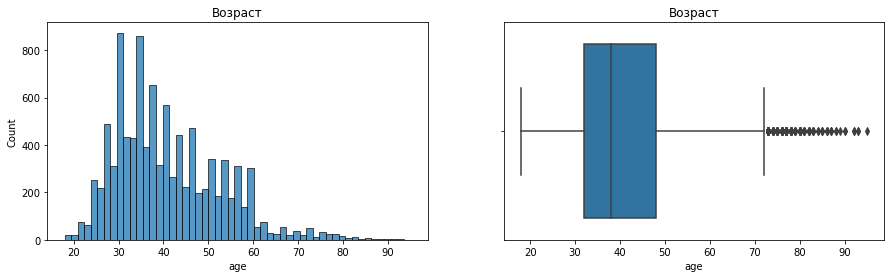

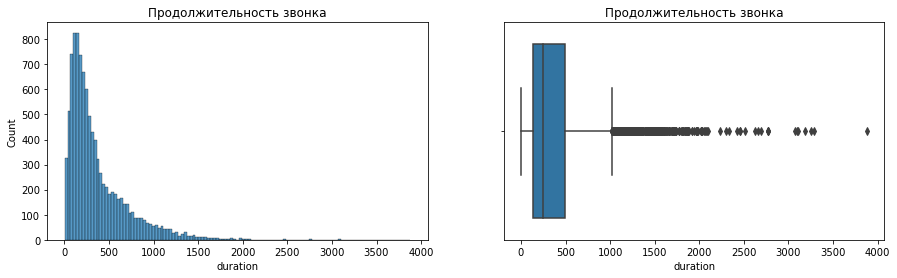

In [91]:
print(cleaned_data.describe())

# Максимальный возраст клиента
print('Максимальный возраст клиента: ', cleaned_data['age'].max())

# Минимальный разговор в секундах
print('Минимальная продолжительность в секундах: ', cleaned_data['duration'].min())

# Посмотрим на бвыбросы по этим двум свойствам

# Возраст
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_data, x='age', ax=axes[0]);
histplot.set_title('Возраст');

boxplot = sns.boxplot(data=cleaned_data, x='age', ax=axes[1]);
boxplot.set_title('Возраст');

# Продолжительность звонка
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_data, x='duration', ax=axes[0]);
histplot.set_title('Продолжительность звонка');

boxplot = sns.boxplot(data=cleaned_data, x='duration', ax=axes[1]);
boxplot.set_title('Продолжительность звонка');



Видно что есть чуть больше 300 звонков с продолжительностью около нуля. Так же есть клиенты возрастом старше 90 лет.

In [92]:
# Меры центральной тенденции

# Возраст
print('Медианное значение возраст: ', median(cleaned_data['age']))
print('Модальное значение: ', mode(cleaned_data['age']))

# Продолжительность звонка
print('Медианное значение продолжительность звонка: ', median(cleaned_data['duration']))
print('Модальное значение продолжительность звонка: ', mode(cleaned_data['duration']))

Медианное значение возраст:  38
Модальное значение:  31
Медианное значение продолжительность звонка:  252
Модальное значение продолжительность звонка:  161


### Описательные статистики для категорий

               job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424  


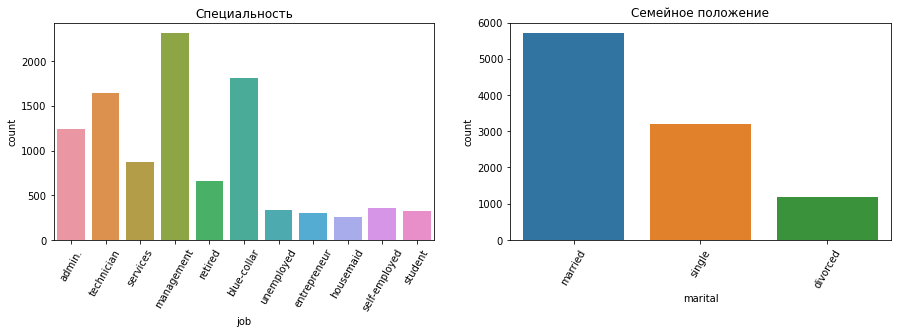

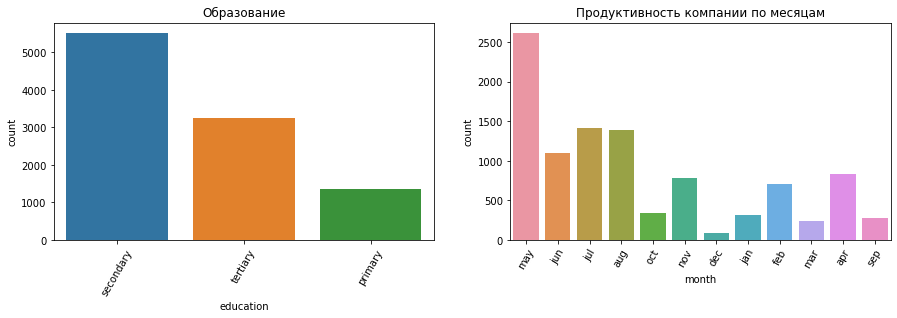

In [93]:
# Описательные статистики для категорий
print(cleaned_data.describe(include='object'))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

job = sns.countplot(data=cleaned_data, x='job', ax=axes[0]);
job.xaxis.set_tick_params(rotation=60)
job.set_title('Специальность');

martial = sns.countplot(data=cleaned_data, x='marital', ax=axes[1]);
martial.xaxis.set_tick_params(rotation=60)
martial.set_title('Семейное положение');

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

education = sns.countplot(data=cleaned_data, x='education', ax=axes[0]);
education.xaxis.set_tick_params(rotation=60)
education.set_title('Образование');

month = sns.countplot(data=cleaned_data, x='month', ax=axes[1]);
month.xaxis.set_tick_params(rotation=60)
month.set_title('Продуктивность компании по месяцам');

Для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

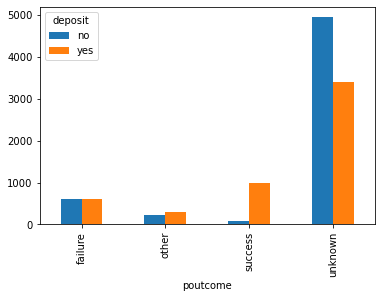

In [94]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar');
    

Посмотрим какой месяц был самым не удачным

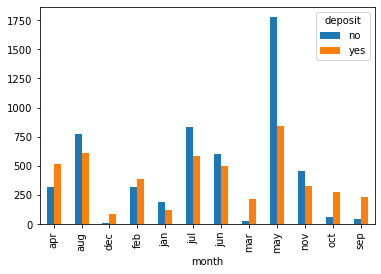

In [95]:
data = cleaned_data.groupby('month')['deposit'].value_counts(normalize=False).unstack()
data.plot(kind='bar');

Вывод: Самым неудачным оказался май. Более 50% отказов

Создадим категориальный признак age_group для разбивки клиентов по возрастным группам

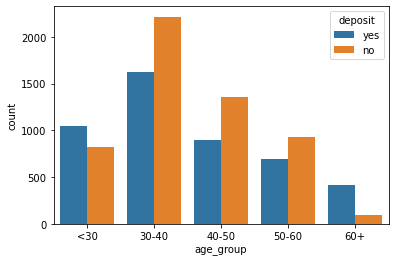

In [96]:
cleaned_data['age_group'] = pd.cut(cleaned_data.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=cleaned_data);

Вывод: в возрастных группах 60+ и <30 количество открывающих депозит преобладает над не открывающими. Особенно эта разница велика в группе 60+. Предположительно это происходит потому, что клиенты этой группы пытаюся создать пенсионные накопления, или это уже пенсионеры которые продолжают работать и откладывают часть денег.

Попробуем отследить зависимости между различными показателями

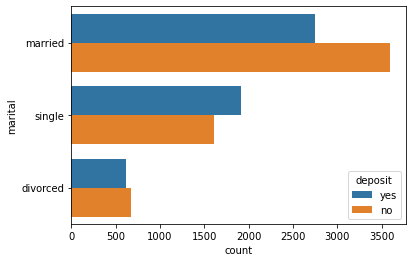

In [97]:
# Клиенты открывшие и неоткрывшие депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=df);

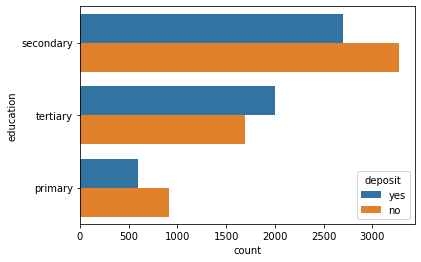

In [98]:
# Клиенты открывшие и неоткрывшие депозит в зависимости от образования
sns.countplot(y='education', hue='deposit', data=df);

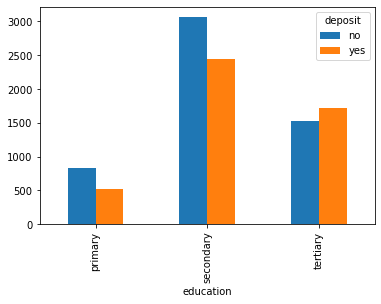

In [99]:
# Клиенты открывшие и неоткрывшие депозит в зависимости от вида профессиональной деятельности
data = cleaned_data.groupby('education')['deposit'].value_counts(normalize=False).unstack()
data.plot(kind='bar');


Посмотрим на зависимости между образованием + семейным статусом к Открыли/Не открыли

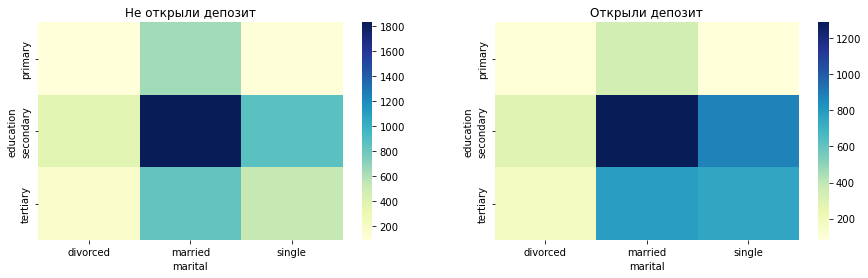

In [100]:
# Люди с каким образованием и семейным статусом Открыли/Не открыли депозит
deposit_yes =  cleaned_data[cleaned_data['deposit'] == 'yes']
deposit_no = cleaned_data[cleaned_data['deposit'] == 'no']

pivot_yes = deposit_yes.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)

pivot_no = deposit_no.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

heatmap = sns.heatmap(data=pivot_no, cmap='YlGnBu', ax=axes[0])
heatmap.set_title('Не открыли депозит');

heatmap = sns.heatmap(data=pivot_yes, cmap='YlGnBu', ax=axes[1])
heatmap.set_title('Открыли депозит');

Проведем преобразование

In [101]:
LE=LabelEncoder()
cleaned_data['education'] = LE.fit_transform(cleaned_data['education'])
cleaned_data['age_group'] = LE.fit_transform(cleaned_data['age_group'])
cleaned_data['deposit'] = LE.fit_transform(cleaned_data['deposit'])
cleaned_data['default'] = LE.fit_transform(cleaned_data['default'])
cleaned_data['housing'] = LE.fit_transform(cleaned_data['housing'])
cleaned_data['loan'] = LE.fit_transform(cleaned_data['loan'])

In [102]:
# Создаем dummy-переменные
dummy_data = pd.get_dummies(cleaned_data)
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

Постороим корреляционную матрицу. Проверим на мультиколлинеарность

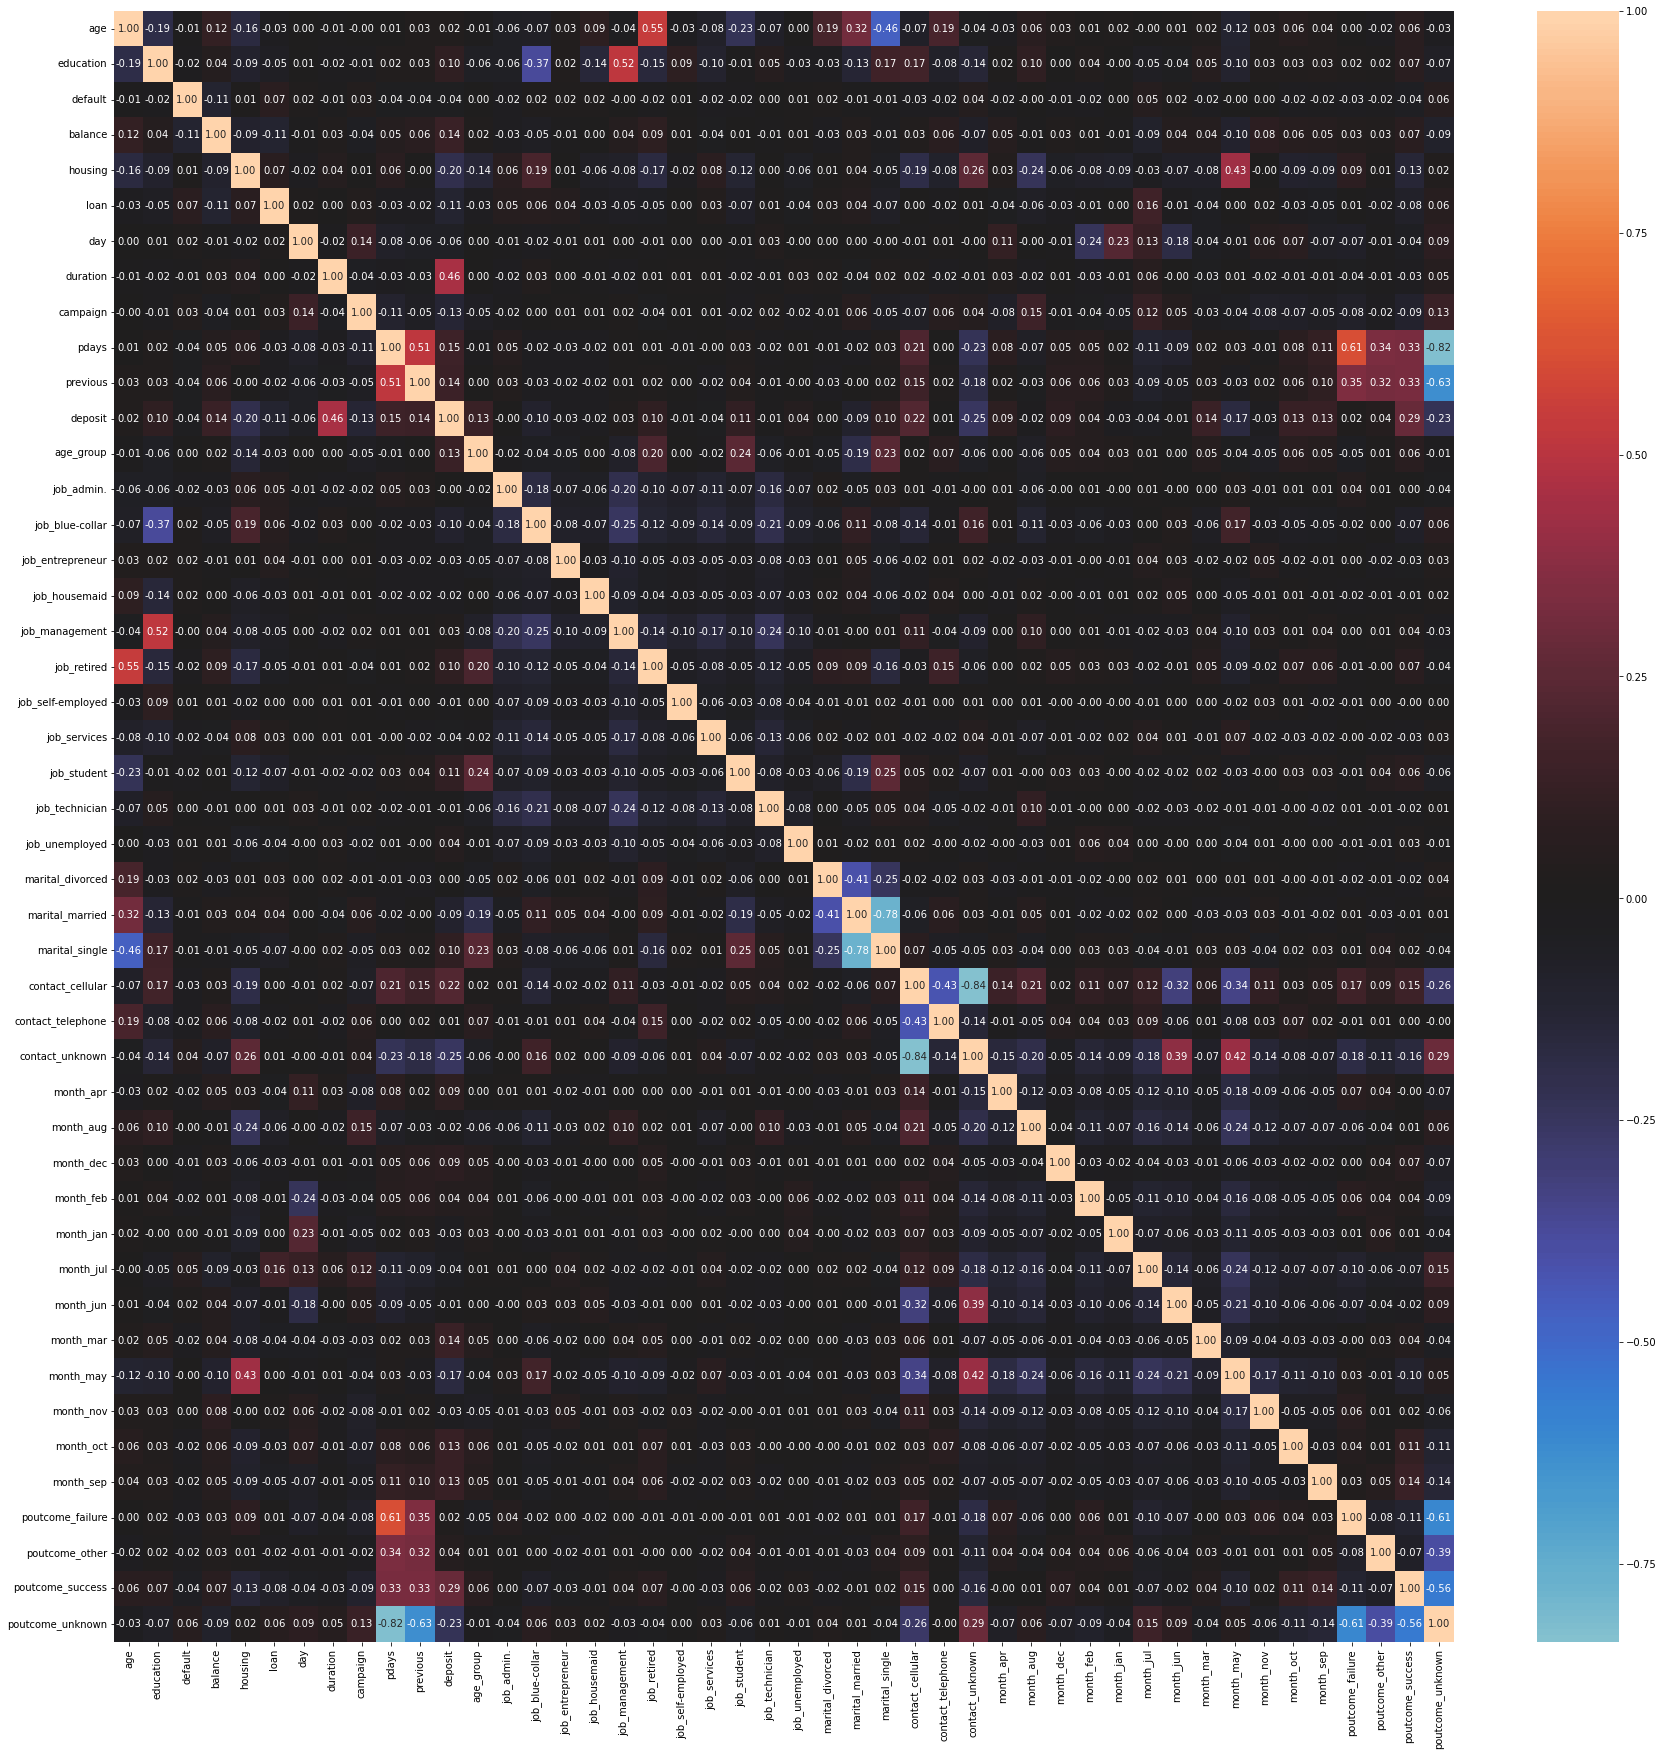

In [103]:
plt.figure(figsize=(30,30))  
sns.heatmap(dummy_data.corr(),fmt='.2f',annot=True, center=0);

ВЫВОД: мультиколлинеарности нет

Разделим данные на тренировочную и тестовоую выборки

In [104]:

X = dummy_data.drop(['deposit'], axis=1)
y = dummy_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3335 entries, 3333 to 3818
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3335 non-null   int64  
 1   education          3335 non-null   int64  
 2   default            3335 non-null   int64  
 3   balance            3335 non-null   float64
 4   housing            3335 non-null   int64  
 5   loan               3335 non-null   int64  
 6   day                3335 non-null   int64  
 7   duration           3335 non-null   int64  
 8   campaign           3335 non-null   int64  
 9   pdays              3335 non-null   int64  
 10  previous           3335 non-null   int64  
 11  age_group          3335 non-null   int64  
 12  job_admin.         3335 non-null   uint8  
 13  job_blue-collar    3335 non-null   uint8  
 14  job_entrepreneur   3335 non-null   uint8  
 15  job_housemaid      3335 non-null   uint8  
 16  job_management     33

Проведем отбор 15-ти наиболее подходящих признаков

In [105]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
best_features = list(selector.get_feature_names_out())
print(best_features)

['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


Нормализуем признаки

In [106]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Решим задачу классификации с помощью логистической регрессии и решающиющих деревьев

In [107]:
# Обучим логистическую регрессию и рассчитаем метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)
y_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



In [108]:
# Обучим решающие деревья, настроим максимальную глубину
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=6,  
    random_state=42 
)
# Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)
y_train_pred = dt_clf.predict(X_train_scaled)
y_pred_test = dt_clf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



In [109]:
# Воспользуемся подбором оптимальных параметров по сетке
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3, 5, 7]}
model_cv = GridSearchCV(
tree.DecisionTreeClassifier(random_state=42, criterion='entropy'),
    param_grid=parameters,
    cv=3,
    scoring='accuracy',
    return_train_score=True
)
model_cv.fit(X_train_scaled, y_train)
print('Лучшие параметры: ', (model_cv.best_params_))
cv_predict = model_cv.predict(X_test_scaled)
print(metrics.classification_report(y_test, cv_predict))

Лучшие параметры:  {'max_depth': 7, 'min_samples_split': 7}
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335



### Решение задачи с помощью ансамблей модели

In [110]:
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    max_depth=10, 
    min_samples_leaf = 5,
    random_state=42 
)
# Обучаем модель 
rf_clf.fit(X_train_scaled, y_train)

y_test_pred = rf_clf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [111]:
# Воспользуемся градиентным бустингом и сравним качество со случайным лесом

gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
gb_predict = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, gb_predict))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Вывод: Преимущества градиентного бустинга перед случайным лесом не видно

### Cтекинг

In [112]:
# Объединяем алгоритмы
estimators = [
    (
        'dt', 
        tree.DecisionTreeClassifier(
            criterion='entropy',
            min_samples_leaf=5,
            max_depth=6,
            random_state=42
        )
    ),
    (
        'log_reg', 
        linear_model.LogisticRegression(
            solver='sag',
            random_state=42 
        )
    ),
    (
        'gb', 
        ensemble.GradientBoostingClassifier(
            learning_rate=0.05,
            n_estimators=300,
            min_samples_leaf=5,
            max_depth=5,
            random_state=42
        )
    )
]
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)
stack_predict = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test, stack_predict))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Вывод: У стекинга показатели немного лучше чем градиентного бустинга и случайного леса

### Оптимизация гиперпараметров с помощью Optuna

In [113]:
import optuna

random_state = 42

def optuna_rf(trial):
    # Задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Cоздаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_test, model.predict(X_test_scaled))

    return score

# Создаем объект исследования
# Указываем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: ", study.best_value)


[I 2022-10-24 14:09:43,355] A new study created in memory with name: RandomForestClassifier
[I 2022-10-24 14:09:44,470] Trial 0 finished with value: 0.8163136263041416 and parameters: {'n_estimators': 160, 'max_depth': 15, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8163136263041416.
[I 2022-10-24 14:09:45,385] Trial 1 finished with value: 0.810054088450525 and parameters: {'n_estimators': 122, 'max_depth': 14, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8163136263041416.
[I 2022-10-24 14:09:46,452] Trial 2 finished with value: 0.8215636822194198 and parameters: {'n_estimators': 158, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8215636822194198.
[I 2022-10-24 14:09:47,316] Trial 3 finished with value: 0.8198482932996207 and parameters: {'n_estimators': 124, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8215636822194198.
[I 2022-10-24 14:09:48,178] Trial 4 finished with value: 0.8167141500474833 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 158, 'max_depth': 15, 'min_samples_leaf': 6}
f1_score на обучающем наборе:  0.8215636822194198


In [114]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
print(metrics.classification_report(y_test, y_train_pred))

accuracy на тестовом наборе: 0.83
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Вывод: Оптимизация с помощью Optuna для данной задачи не дает преимуществ. Сравнивая метрики наиболее удачным решением оказались логистическая регрессия и решающие деревья.